# Esmaeil Rezaei

# March Madness 2024 with 514,193,368 Observations

***Here is the steps to tackle this dataset***:

- `WinTeam` is considered as `team A` and `LTeam` as `team B`
- The goal is to predict if `A` beats `B`
- Value 1 is assigned to the `y` for actual winners in the dataset
- The related values of the winning team are switched with the losing teams and set to zero for `y`
- For each team, feasures are computed for the last year because we the result of the current year is unknown.
- The data related to years from 1985 to 2023 are considered as training and 2024 as testing
- Logistic Regression is used first for feature selection and then for classification
- Teams in different regions are randomly seeded. Then, losers are removed and winners are seeded for the next games until slot `R6CH`.

***The features defined in this problem are as follows***:

1. **ATeamID**: Considered as `team A`, winer, where `y = 1` if it wins.
2. **BTeamID**: Considered as `team B`, losser, where `y = 0` if A wins and vice versa.
3. **avg(AScoreDiff)**: Average scores for 'team A' in each year.
4. **avg(BScoreDiff)**: Average scores for 'team B' in each year.
5. **stddev(AScoreDiff)**: Standard deiation of scores for 'team A' in each year. It is measured to differentiate teams that consistently perform well versus those with more erratic performance patterns over time.
6. **stddev(BScoreDiff)**: Standard deiation of scores for 'team B' in each year. It is measured to differentiate teams that consistently perform well versus those with more erratic performance patterns over time.
7. **prob_AWin**: Serves as 'y' variable for probability 'team A' wins.

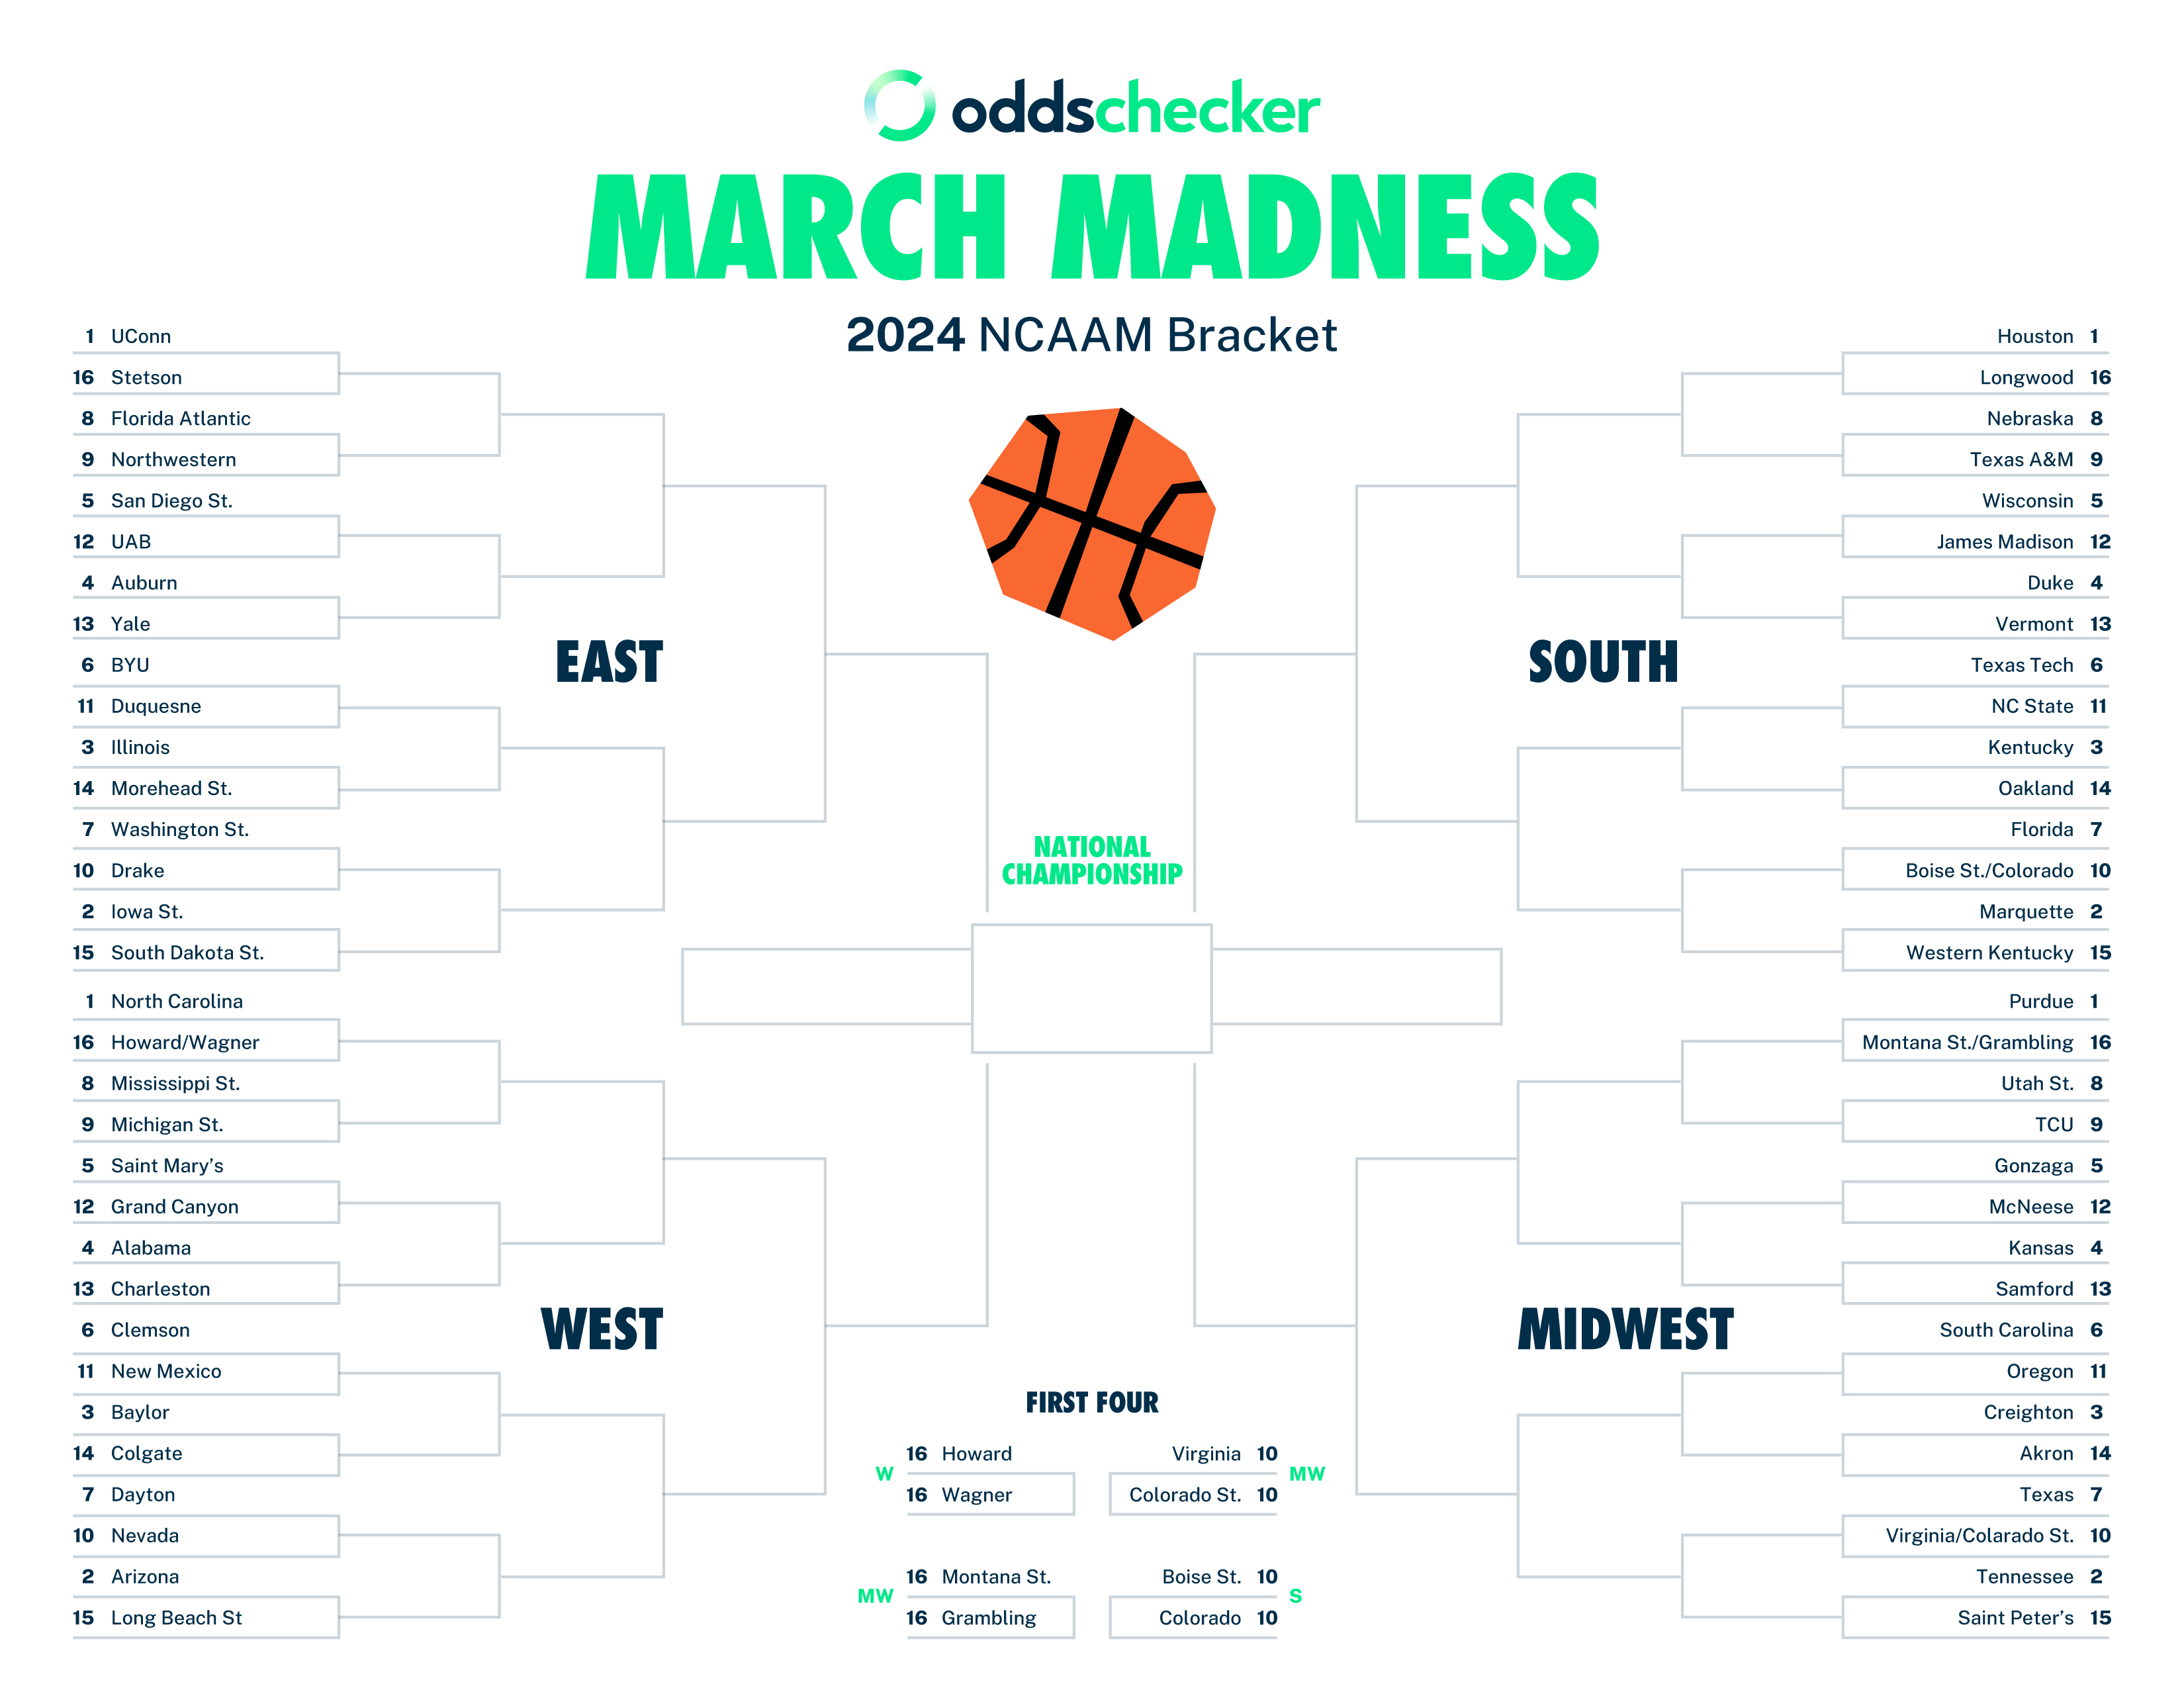

In [1]:
path = "/kaggle/input/march-machine-learning-mania-2024/"

In [2]:
import numpy as np
import pandas as pd
!pip install pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Men dataset

# EDA

In [3]:
# Creating a SparkSession named 'MarchMadness' for our Spark application
spark = SparkSession.builder.appName('MarchMadness').getOrCreate()

### Read the Men Files

In [4]:
# Importing necessary functions from the PySpark SQL functions module
from pyspark.sql.functions import asc, desc, lit, count, col, stddev, rand, cast, std
# Reading the CSV file "MNCAATourneySeeds.csv"
Seeds_Men = spark.read.csv(path + "MNCAATourneySeeds.csv", header = 'True')
# Removing any duplicate rows
Seeds_Men = Seeds_Men.dropDuplicates()
# Sorting the Seeds_Men DataFrame by the 'Season' column in ascending order
Seeds_Men = Seeds_Men.orderBy(asc("Season"))
Seeds_Men.show()

+------+----+------+
|Season|Seed|TeamID|
+------+----+------+
|  1985| Y01|  1328|
|  1985| X03|  1301|
|  1985| X11|  1431|
|  1985| W01|  1207|
|  1985| W14|  1318|
|  1985| W04|  1260|
|  1985| X02|  1433|
|  1985| W09|  1439|
|  1985| X04|  1424|
|  1985| W08|  1396|
|  1985| X14|  1305|
|  1985| Z15|  1292|
|  1985| Z06|  1345|
|  1985| Y04|  1326|
|  1985| Z05|  1268|
|  1985| X07|  1104|
|  1985| Z03|  1242|
|  1985| W16|  1250|
|  1985| W10|  1177|
|  1985| X12|  1246|
+------+----+------+
only showing top 20 rows



In [5]:
# Importing monotonically_increasing_id to let add id column with a fixed number
from pyspark.sql.functions import monotonically_increasing_id
# Reading the CSV file "MRegularSeasonCompactResults.csv"
Season_Men = spark.read.csv(path + "MRegularSeasonCompactResults.csv", header = 'True')
# Selecting all columns except the last two
Season_Men = Season_Men.select(Season_Men.columns[:-2])
# Removing any duplicate rows
Season_Men = Season_Men.dropDuplicates()
# Dropping the 'DayNum' colum
Season_Men = Season_Men.drop('DayNum') # it did not significantly improve the accuracy

# Adding a new column 'id' with monotonically increasing unique identifiers
Seeds_Men = Seeds_Men.select("*").withColumn("id", monotonically_increasing_id())
Season_Men = Season_Men.select("*").withColumn("id", monotonically_increasing_id())

Note that for adding a column we need to form a new dataframe. Pyspark does not alllow to add a column to the previous data.

In [6]:
# Displaying the first 8 rows of the Season_Men DataFrame
Season_Men.limit(8).show()

+------+-------+------+-------+------+---+
|Season|WTeamID|WScore|LTeamID|LScore| id|
+------+-------+------+-------+------+---+
|  1985|   1234|    89|   1287|    46|  0|
|  1985|   1261|    88|   1423|    65|  1|
|  1985|   1354|    66|   1106|    61|  2|
|  1985|   1270|    86|   1368|    68|  3|
|  1985|   1227|    75|   1156|    72|  4|
|  1985|   1162|    72|   1264|    59|  5|
|  1985|   1174|    51|   1248|    49|  6|
|  1985|   1287|    67|   1464|    65|  7|
+------+-------+------+-------+------+---+



In PySpark, there isn't a direct `tail()` function like in pandas. Instead, you can achieve similar functionality using the `orderBy()` function in combination with `limit()`.

In [7]:
# Ordering the Season_Men DataFrame by descending order of the 'id' column and selecting the last 5 rows
Season_Men.orderBy(desc("id")).limit(5).show()

+------+-------+------+-------+------+----------+
|Season|WTeamID|WScore|LTeamID|LScore|        id|
+------+-------+------+-------+------+----------+
|  2024|   1396|    58|   1150|    54|8590028330|
|  2024|   1170|    74|   1186|    69|8590028329|
|  2024|   1332|    78|   1333|    71|8590028328|
|  2024|   1110|    73|   1119|    51|8590028327|
|  2024|   1269|    69|   1203|    57|8590028326|
+------+-------+------+-------+------+----------+



In [8]:
# The last 5 rows
Season_Men.tail(5)

[Row(Season='2024', WTeamID='1269', WScore='69', LTeamID='1203', LScore='57', id=8590028326),
 Row(Season='2024', WTeamID='1110', WScore='73', LTeamID='1119', LScore='51', id=8590028327),
 Row(Season='2024', WTeamID='1332', WScore='78', LTeamID='1333', LScore='71', id=8590028328),
 Row(Season='2024', WTeamID='1170', WScore='74', LTeamID='1186', LScore='69', id=8590028329),
 Row(Season='2024', WTeamID='1396', WScore='58', LTeamID='1150', LScore='54', id=8590028330)]

In [9]:
# Printing the schema of the Season_Men DataFrame
Season_Men.printSchema()

root
 |-- Season: string (nullable = true)
 |-- WTeamID: string (nullable = true)
 |-- WScore: string (nullable = true)
 |-- LTeamID: string (nullable = true)
 |-- LScore: string (nullable = true)
 |-- id: long (nullable = false)



In [10]:
Season_Men = Season_Men.select([col(column).cast("double").alias(column) for column in Season_Men.columns])
Season_Men.printSchema()

root
 |-- Season: double (nullable = true)
 |-- WTeamID: double (nullable = true)
 |-- WScore: double (nullable = true)
 |-- LTeamID: double (nullable = true)
 |-- LScore: double (nullable = true)
 |-- id: double (nullable = false)



In [11]:
# Dropping rows with any null values from the Season_Men DataFrame
Season_Men = Season_Men.na.drop(how = 'any')

In [12]:
# Shape of a DataFrame in Pyspark

#Counting the number of rows in the Season_Men DataFrame
num_rows = Season_Men.count()
# Counting the number of columns in the Season_Men DataFrame
num_columns = len(Season_Men.columns)

print("Shape of Season_Men DataFrame: {} rows x {} columns".format(num_rows, num_columns))

Shape of Season_Men DataFrame: 187289 rows x 6 columns


In [13]:
# Renaming columns in the Season_Men DataFrame
Season_Men = Season_Men.withColumnRenamed("WTeamID", "ATeamID")\
.withColumnRenamed("WScore", "AScore")\
.withColumnRenamed("LTeamID", "BTeamID")\
.withColumnRenamed("LScore", "BScore")\

# Dropping the 'id' column: Automaticlly drops columns not rows
Season_Men= Season_Men.drop("id")
Season_Men.show()

+------+-------+------+-------+------+
|Season|ATeamID|AScore|BTeamID|BScore|
+------+-------+------+-------+------+
|1985.0| 1234.0|  89.0| 1287.0|  46.0|
|1985.0| 1261.0|  88.0| 1423.0|  65.0|
|1985.0| 1354.0|  66.0| 1106.0|  61.0|
|1985.0| 1270.0|  86.0| 1368.0|  68.0|
|1985.0| 1227.0|  75.0| 1156.0|  72.0|
|1985.0| 1162.0|  72.0| 1264.0|  59.0|
|1985.0| 1174.0|  51.0| 1248.0|  49.0|
|1985.0| 1287.0|  67.0| 1464.0|  65.0|
|1985.0| 1103.0|  71.0| 1287.0|  61.0|
|1985.0| 1320.0|  70.0| 1410.0|  68.0|
|1985.0| 1215.0|  59.0| 1147.0|  57.0|
|1985.0| 1154.0|  82.0| 1172.0|  79.0|
|1985.0| 1227.0|  66.0| 1453.0|  62.0|
|1985.0| 1301.0|  70.0| 1155.0|  63.0|
|1986.0| 1344.0| 107.0| 1135.0|  80.0|
|1986.0| 1388.0|  84.0| 1463.0|  81.0|
|1986.0| 1231.0|  84.0| 1256.0|  63.0|
|1986.0| 1345.0|  85.0| 1321.0|  64.0|
|1986.0| 1250.0|  54.0| 1352.0|  53.0|
|1986.0| 1293.0|  72.0| 1122.0|  65.0|
+------+-------+------+-------+------+
only showing top 20 rows



# Feature Engineering

In [14]:
# For winders

# Grouping by "Season" and "ATeamID" and aggregating the counts
Season_Men_AWgouped = Season_Men.groupBy("Season", "ATeamID").agg(count("*").alias("count"))
# Sorting the grouped data by "Season" and "ATeamID"
Season_Men_AWgouped = Season_Men_AWgouped.sort(["Season", "ATeamID"])

Season_Men_AWgouped.show()

+------+-------+-----+
|Season|ATeamID|count|
+------+-------+-----+
|1985.0| 1102.0|    5|
|1985.0| 1103.0|    9|
|1985.0| 1104.0|   21|
|1985.0| 1106.0|   10|
|1985.0| 1108.0|   19|
|1985.0| 1109.0|    1|
|1985.0| 1110.0|    7|
|1985.0| 1111.0|   10|
|1985.0| 1112.0|   18|
|1985.0| 1113.0|   11|
|1985.0| 1114.0|   17|
|1985.0| 1116.0|   21|
|1985.0| 1117.0|   11|
|1985.0| 1119.0|   15|
|1985.0| 1120.0|   18|
|1985.0| 1121.0|    7|
|1985.0| 1122.0|    6|
|1985.0| 1123.0|   13|
|1985.0| 1124.0|    7|
|1985.0| 1126.0|    6|
+------+-------+-----+
only showing top 20 rows



In [15]:
# For lossers

# Grouping by "Season" and "BTeamID" and aggregating the counts
Season_Men_BWgouped = Season_Men.groupBy("Season", "BTeamID").agg(count("*").alias("count"))
# Sorting the grouped data by "Season" and "BTeamID"
Season_Men_BWgouped = Season_Men_BWgouped.sort(["Season", "BTeamID"])

Season_Men_BWgouped.show()

+------+-------+-----+
|Season|BTeamID|count|
+------+-------+-----+
|1985.0| 1102.0|   19|
|1985.0| 1103.0|   14|
|1985.0| 1104.0|    9|
|1985.0| 1106.0|   14|
|1985.0| 1108.0|    6|
|1985.0| 1109.0|   23|
|1985.0| 1110.0|   18|
|1985.0| 1111.0|   14|
|1985.0| 1112.0|    9|
|1985.0| 1113.0|   16|
|1985.0| 1114.0|   13|
|1985.0| 1116.0|   12|
|1985.0| 1117.0|   14|
|1985.0| 1119.0|   13|
|1985.0| 1120.0|   11|
|1985.0| 1121.0|   19|
|1985.0| 1122.0|   17|
|1985.0| 1123.0|   16|
|1985.0| 1124.0|   17|
|1985.0| 1126.0|   19|
+------+-------+-----+
only showing top 20 rows



In [16]:
# Adding column 'AScoreDiff' to represent the score difference between Team A and Team B
Season_Men = Season_Men.withColumn('AScoreDiff', Season_Men["AScore"] - Season_Men["BScore"])
# Adding column 'BScoreDiff' as score difference between Team B and Team A
Season_Men = Season_Men.withColumn('BScoreDiff', -Season_Men['AScoreDiff'])

Season_Men.show()

+------+-------+------+-------+------+----------+----------+
|Season|ATeamID|AScore|BTeamID|BScore|AScoreDiff|BScoreDiff|
+------+-------+------+-------+------+----------+----------+
|1985.0| 1234.0|  89.0| 1287.0|  46.0|      43.0|     -43.0|
|1985.0| 1261.0|  88.0| 1423.0|  65.0|      23.0|     -23.0|
|1985.0| 1354.0|  66.0| 1106.0|  61.0|       5.0|      -5.0|
|1985.0| 1270.0|  86.0| 1368.0|  68.0|      18.0|     -18.0|
|1985.0| 1227.0|  75.0| 1156.0|  72.0|       3.0|      -3.0|
|1985.0| 1162.0|  72.0| 1264.0|  59.0|      13.0|     -13.0|
|1985.0| 1174.0|  51.0| 1248.0|  49.0|       2.0|      -2.0|
|1985.0| 1287.0|  67.0| 1464.0|  65.0|       2.0|      -2.0|
|1985.0| 1103.0|  71.0| 1287.0|  61.0|      10.0|     -10.0|
|1985.0| 1320.0|  70.0| 1410.0|  68.0|       2.0|      -2.0|
|1985.0| 1215.0|  59.0| 1147.0|  57.0|       2.0|      -2.0|
|1985.0| 1154.0|  82.0| 1172.0|  79.0|       3.0|      -3.0|
|1985.0| 1227.0|  66.0| 1453.0|  62.0|       4.0|      -4.0|
|1985.0| 1301.0|  70.0| 

In [17]:
# Describe the statistics of the Season_Men DataFrame and display the results
Season_Men.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|            Season|           ATeamID|            AScore|           BTeamID|            BScore|       AScoreDiff|       BScoreDiff|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|  count|            187289|            187289|            187289|            187289|            187289|           187289|           187289|
|   mean|2005.8205607376835| 1287.487423180219| 76.80297828489661|1283.1385345642295| 64.72848378708841| 12.0744944978082|-12.0744944978082|
| stddev|11.389584899732073|104.84008160953823|11.859694025349647|104.98223419774374|11.215262140202697|9.382254544472188|9.382254544472188|
|    min|            1985.0|            1101.0|              34.0|            1101.0|              20.0|              1.0|            -94.0|
|    max|    

In [18]:
# Calculate the mean of AScoreDiff grouped by Season and ATeamID
AScoreDiff_mean_grouped = Season_Men.groupBy("Season", "ATeamID").mean("AScoreDiff")
# Calculate the mean of BScoreDiff grouped by Season and BTeamID
BScoreDiff_mean_grouped = Season_Men.groupBy("Season", "BTeamID").mean("BScoreDiff")
# Calculate the standard deviation of AScoreDiff grouped by Season and ATeamID
AScoreDiff_std_grouped = Season_Men.groupBy("Season", "ATeamID").agg(stddev("AScoreDiff"))
# Calculate the standard deviation of BScoreDiff grouped by Season and BTeamID
BScoreDiff_std_grouped = Season_Men.groupBy("Season", "BTeamID").agg(stddev("BScoreDiff"))
# Join the mean and standard deviation dataframes for ATeamID
merged_A_groups = AScoreDiff_mean_grouped.join(AScoreDiff_std_grouped, on=['Season', 'ATeamID'], how='left_outer')
merged_A_groups.show()

+------+-------+------------------+------------------+
|Season|ATeamID|   avg(AScoreDiff)|stddev(AScoreDiff)|
+------+-------+------------------+------------------+
|1993.0| 1309.0|             14.56|  8.39186113644246|
|2001.0| 1408.0| 9.285714285714286| 2.811540841738193|
|2006.0| 1369.0|               7.4| 4.393176527297759|
|2014.0| 1292.0|              12.5| 8.122572897560875|
|1991.0| 1120.0|  8.76923076923077| 7.037445632162355|
|1993.0| 1301.0|              7.75|  8.90826261720785|
|2002.0| 1183.0|               9.0| 7.675225788801975|
|2007.0| 1142.0|11.705882352941176| 6.944104566846191|
|2009.0| 1428.0|12.708333333333334|  7.97539240777349|
|2012.0| 1317.0|13.266666666666667|11.871133455732421|
|2013.0| 1400.0|             12.75| 7.380153566604605|
|1993.0| 1285.0| 7.857142857142857|6.0365189007871445|
|1994.0| 1356.0|12.227272727272727| 9.065538190531365|
|2019.0| 1281.0|              12.6| 7.317298486658662|
|2008.0| 1135.0|12.473684210526315| 8.421984597552022|
|2011.0| 1

In [19]:
# Join the mean and standard deviation dataframes for BTeamID
merged_B_groups = BScoreDiff_mean_grouped.join(BScoreDiff_std_grouped, on=['Season', 'BTeamID'], how='left_outer')
merged_B_groups.show()

+------+-------+-------------------+------------------+
|Season|BTeamID|    avg(BScoreDiff)|stddev(BScoreDiff)|
+------+-------+-------------------+------------------+
|1986.0| 1122.0|-12.714285714285714|  9.65105471660259|
|2004.0| 1394.0|-15.454545454545455|12.388411006772712|
|2007.0| 1246.0| -7.545454545454546| 5.106146029318714|
|2016.0| 1247.0| -17.59090909090909|10.900673159244585|
|1990.0| 1386.0|-14.523809523809524| 6.652962104349067|
|1995.0| 1220.0| -12.38888888888889| 9.708328073717334|
|2015.0| 1160.0|-11.823529411764707| 9.098319172501363|
|1991.0| 1200.0|               -8.0| 6.506407098647712|
|1999.0| 1220.0| -11.88888888888889|11.118053386771946|
|2007.0| 1206.0|               -8.8|5.8943071809040575|
|2019.0| 1281.0|-12.176470588235293| 7.907554094959193|
|2003.0| 1254.0|-13.842105263157896|12.464452378641239|
|1994.0| 1110.0| -15.31578947368421| 8.800584775891931|
|2001.0| 1408.0|-17.285714285714285|  11.7351730159502|
|2007.0| 1425.0| -9.454545454545455| 6.976584212

In [20]:
# Join the mean and standard deviation dataframes for BTeamID
Season_Men = Season_Men.join(merged_A_groups, on=["Season", "ATeamID"], how = "left_outer")
Season_Men.show()

+------+-------+------+-------+------+----------+----------+------------------+------------------+
|Season|ATeamID|AScore|BTeamID|BScore|AScoreDiff|BScoreDiff|   avg(AScoreDiff)|stddev(AScoreDiff)|
+------+-------+------+-------+------+----------+----------+------------------+------------------+
|1985.0| 1103.0|  71.0| 1287.0|  61.0|      10.0|     -10.0| 7.555555555555555| 6.105553028004734|
|1985.0| 1131.0|  82.0| 1263.0|  73.0|       9.0|      -9.0|12.785714285714286| 8.894065190023941|
|1985.0| 1132.0|  66.0| 1141.0|  58.0|       8.0|      -8.0| 7.181818181818182|  8.10947818072386|
|1985.0| 1154.0|  82.0| 1172.0|  79.0|       3.0|      -3.0| 8.733333333333333| 5.457192719792144|
|1985.0| 1162.0|  72.0| 1264.0|  59.0|      13.0|     -13.0|              8.25| 4.788717801438938|
|1985.0| 1162.0|  67.0| 1171.0|  63.0|       4.0|      -4.0|              8.25| 4.788717801438938|
|1985.0| 1166.0|  60.0| 1323.0|  58.0|       2.0|      -2.0|               9.0| 8.888194417315589|
|1985.0| 1

In [21]:
# Join Season_Men dataframe with merged_B_groups dataframe on columns Season and BTeamID
df1 = Season_Men.join(merged_B_groups, on=["Season", "BTeamID"], how = "left_outer")
df1.show()

+------+-------+-------+------+------+----------+----------+------------------+------------------+-------------------+------------------+
|Season|BTeamID|ATeamID|AScore|BScore|AScoreDiff|BScoreDiff|   avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|
+------+-------+-------+------+------+----------+----------+------------------+------------------+-------------------+------------------+
|1985.0| 1278.0| 1234.0|  70.0|  65.0|       5.0|      -5.0|             18.45|13.359305843926881|-12.733333333333333|10.250203250017371|
|1985.0| 1266.0| 1243.0|  55.0|  54.0|       1.0|      -1.0|13.916666666666666|13.324334084218947|               -9.0| 5.944184833375669|
|1985.0| 1248.0| 1174.0|  51.0|  49.0|       2.0|      -2.0| 6.545454545454546| 5.574291638650356|-10.076923076923077|12.552964712645498|
|1985.0| 1447.0| 1192.0|  82.0|  72.0|      10.0|     -10.0| 8.210526315789474|  7.05202057229322|            -10.375| 8.212794895770866|
|1985.0| 1288.0| 1224.0|  83.0|  6

In [22]:
# Define the list of feature columns to select
feature_cols = ["Season", "ATeamID", "BTeamID", "avg(AScoreDiff)", "stddev(AScoreDiff)", "avg(BScoreDiff)", "stddev(BScoreDiff)"]
# Select the specified feature columns from df1
df1 = df1.select(feature_cols)
df1.show()

+------+-------+-------+------------------+------------------+-------------------+------------------+
|Season|ATeamID|BTeamID|   avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|
+------+-------+-------+------------------+------------------+-------------------+------------------+
|1985.0| 1234.0| 1278.0|             18.45|13.359305843926881|-12.733333333333333|10.250203250017371|
|1985.0| 1243.0| 1266.0|13.916666666666666|13.324334084218947|               -9.0| 5.944184833375669|
|1985.0| 1174.0| 1248.0| 6.545454545454546| 5.574291638650356|-10.076923076923077|12.552964712645498|
|1985.0| 1192.0| 1447.0| 8.210526315789474|  7.05202057229322|            -10.375| 8.212794895770866|
|1985.0| 1224.0| 1288.0|              10.5| 6.077280093375105|-25.958333333333332|16.971790320018293|
|1985.0| 1227.0| 1156.0| 7.923076923076923|  6.73871326072392|             -7.125|3.6030740843261686|
|1985.0| 1215.0| 1147.0|               7.0| 5.264435935053794|              -15.5|

In [23]:
# Add a new column 'prob_AWin' with a constant value of 1 to df1
df1 = df1.withColumn('prob_AWin', lit(1))
df1.show()

+------+-------+-------+------------------+------------------+-------------------+------------------+---------+
|Season|ATeamID|BTeamID|   avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|prob_AWin|
+------+-------+-------+------------------+------------------+-------------------+------------------+---------+
|1985.0| 1132.0| 1141.0| 7.181818181818182|  8.10947818072386|-10.166666666666666| 7.957608272073005|        1|
|1985.0| 1215.0| 1147.0|               7.0| 5.264435935053794|              -15.5| 9.445132413883327|        1|
|1985.0| 1227.0| 1156.0| 7.923076923076923|  6.73871326072392|             -7.125|3.6030740843261686|        1|
|1985.0| 1162.0| 1171.0|              8.25| 4.788717801438938|             -14.75| 9.791913957310308|        1|
|1985.0| 1154.0| 1172.0| 8.733333333333333| 5.457192719792144| -7.947368421052632| 6.899868631684441|        1|
|1985.0| 1250.0| 1180.0|               6.0| 6.115553940568262|-12.222222222222221| 8.875316435489236|   

In [24]:
# Generate a new DataFrame by switching values of winners (A) with losers (B) and setting the probability to 0
df2 = df1.select(
    col("Season"),
    col("BTeamID").alias("ATeamID"),
    col("ATeamID").alias("BTeamID"),
    col("avg(BScoreDiff)").alias("avg(AScoreDiff)"),
    col("stddev(BScoreDiff)").alias("stddev(AScoreDiff)"),
    col("avg(AScoreDiff)").alias(" avg(BScoreDiff)"),
    col("stddev(AScoreDiff)").alias("stddev(BScoreDiff)"),
)
# Add zero probability of team A winning the game
df2 = df2.withColumn("prob_AWin", lit(0))
df2.show()

+------+-------+-------+-------------------+------------------+------------------+------------------+---------+
|Season|ATeamID|BTeamID|    avg(AScoreDiff)|stddev(AScoreDiff)|   avg(BScoreDiff)|stddev(BScoreDiff)|prob_AWin|
+------+-------+-------+-------------------+------------------+------------------+------------------+---------+
|1985.0| 1278.0| 1234.0|-12.733333333333333|10.250203250017371|             18.45|13.359305843926881|        0|
|1985.0| 1266.0| 1243.0|               -9.0| 5.944184833375669|13.916666666666666|13.324334084218947|        0|
|1985.0| 1248.0| 1174.0|-10.076923076923077|12.552964712645498| 6.545454545454546| 5.574291638650356|        0|
|1985.0| 1447.0| 1192.0|            -10.375| 8.212794895770866| 8.210526315789474|  7.05202057229322|        0|
|1985.0| 1288.0| 1224.0|-25.958333333333332|16.971790320018293|              10.5| 6.077280093375105|        0|
|1985.0| 1156.0| 1227.0|             -7.125|3.6030740843261686| 7.923076923076923|  6.73871326072392|   

In [25]:
# Concatenate the two DataFrames into a single DataFrame
df = df1.union(df2)
# Shuffle the rows of the DataFrame
df = df.orderBy(rand())

df.show()

+------+-------+-------+-------------------+------------------+-------------------+------------------+---------+
|Season|ATeamID|BTeamID|    avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|prob_AWin|
+------+-------+-------+-------------------+------------------+-------------------+------------------+---------+
|2013.0| 1311.0| 1322.0|  9.333333333333334| 8.246211251235321|              -10.0| 6.279217421667402|        1|
|2005.0| 1333.0| 1390.0|-14.714285714285714|12.085774036690164| 10.444444444444445|5.2493385826745405|        0|
|2024.0| 1330.0| 1111.0|             -11.24|  6.99571297295708|              13.12| 8.293169880490009|        0|
|2021.0| 1167.0| 1169.0| 12.153846153846153| 7.787234787845146|-14.461538461538462|13.586852619446644|        1|
|2007.0| 1359.0| 1404.0|  8.533333333333333|6.7280507330627835|-12.304347826086957|   8.7408902324269|        1|
|1991.0| 1371.0| 1155.0| 14.714285714285714|14.588155665274678|-13.352941176470589| 7.5988582733

In [26]:
print('The size of the dataframe 1 is: {}'.format(df1.count()))
print('The size of the dataframe 2 is: {}'.format(df2.count()))
print('The size of the concatenated dataframes is: {}'.format(df.count()))

The size of the dataframe 1 is: 187289
The size of the dataframe 2 is: 187289
The size of the concatenated dataframes is: 374578


In [27]:
df.dtypes

[('Season', 'double'),
 ('ATeamID', 'double'),
 ('BTeamID', 'double'),
 ('avg(AScoreDiff)', 'double'),
 ('stddev(AScoreDiff)', 'double'),
 ('avg(BScoreDiff)', 'double'),
 ('stddev(BScoreDiff)', 'double'),
 ('prob_AWin', 'int')]

In [28]:
# We consider the avg and std values of the last year for each current year because
# we don't know which team has won. To do so, we use a trick that adds 1 year to the
# seasons. Therefore, in the new dataset, values are actually the values of the
# last year.

# columns for the current year
left_df = df.select(["Season", "ATeamID", "BTeamID", "prob_AWin"])
# Create a temporary DataFrame with the season shifted by 1 year to be assinged as last year data to the left_df
df_temp2 = df.withColumn('Season1', col("Season")+1).drop('Season').withColumnRenamed('Season1', "Season").drop("prob_AWin")

# Join the original DataFrame with the temporary DataFrame to get the average and standard deviation values for each team at position winer (A)
df = left_df.join(df_temp2.select(["Season", "ATeamID", "avg(AScoreDiff)", "stddev(AScoreDiff)"]), on=["Season", "ATeamID"], how="left_outer")
# Join the original DataFrame with the temporary DataFrame to get the average and standard deviation values for each team at position losser (B)
df = df.join(df_temp2.select(["Season", "BTeamID", "avg(BScoreDiff)", "stddev(BScoreDiff)"]), on=["Season", "BTeamID"], how="left_outer")

# Filter the DataFrame to keep seasons between 1986 and 2024, fill null values with 0, and order by a random column
df = df.where((col("Season") > 1985.0) & (col("Season") < 2025))
df = df.fillna(0, subset=df.columns)
df_Men = df.orderBy(rand())
df_Men = df_Men.withColumn('tournament ', lit('M'))
df_Men.show()

+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|Season|BTeamID|ATeamID|prob_AWin|    avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|tournament |
+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|2013.0| 1352.0| 1148.0|        0|            -12.125| 9.450749529358328|               11.0|  8.38217570593801|          M|
|2008.0| 1210.0| 1150.0|        0|           -13.9375| 8.970089185732771|               19.8|14.140646899517792|          M|
|2006.0| 1286.0| 1363.0|        0|  5.666666666666667| 7.004760286167305|-13.142857142857142| 9.898384816626498|          M|
|2020.0| 1177.0| 1437.0|        1|              13.08| 8.528970238741213|-11.066666666666666|6.0764964843081675|          M|
|1989.0| 1271.0| 1274.0|        1|-15.615384615384615|11.228968945978236|-15.714285714285714|13.457870771941812|          M|


# Do the same for women dataset

In [29]:
# Reading the CSV file "MNCAATourneySeeds.csv"
Seeds_Women = spark.read.csv(path + "WNCAATourneySeeds.csv", header = 'True')
# Removing any duplicate rows
Seeds_Women = Seeds_Women.dropDuplicates()
# Sorting the Seeds_Women DataFrame by the 'Season' column in ascending order
Seeds_Women = Seeds_Women.orderBy(asc("Season"))



# Reading the CSV file "MRegularSeasonCompactResults.csv"
Seeds_Women = spark.read.csv(path + "WRegularSeasonCompactResults.csv", header = 'True')
# Selecting all columns except the last two
Seeds_Women = Seeds_Women.select(Seeds_Women.columns[:-2])
# Removing any duplicate rows
Seeds_Women = Seeds_Women.dropDuplicates()
# Dropping the 'DayNum' colum
Seeds_Women = Seeds_Women.drop('DayNum') # it did not significantly improve the accuracy

# Adding a new column 'id' with monotonically increasing unique identifiers
Seeds_Women = Seeds_Women.select("*").withColumn("id", monotonically_increasing_id())
Seeds_Women = Seeds_Women.select("*").withColumn("id", monotonically_increasing_id())




# Renaming columns in the Seeds_Women DataFrame
Seeds_Women = Seeds_Women.withColumnRenamed("WTeamID", "ATeamID")\
.withColumnRenamed("WScore", "AScore")\
.withColumnRenamed("LTeamID", "BTeamID")\
.withColumnRenamed("LScore", "BScore")\

# Dropping the 'id' column: Automaticlly drops columns not rows
Seeds_Women = Seeds_Women.drop("id")

# For winders
# Grouping by "Season" and "ATeamID" and aggregating the counts
Seeds_Women_AWgouped = Seeds_Women.groupBy("Season", "ATeamID").agg(count("*").alias("count"))
# Sorting the grouped data by "Season" and "ATeamID"
Seeds_Women_AWgouped = Seeds_Women_AWgouped.sort(["Season", "ATeamID"])

# For lossers
# Grouping by "Season" and "BTeamID" and aggregating the counts
Seeds_Women_BWgouped = Seeds_Women.groupBy("Season", "BTeamID").agg(count("*").alias("count"))
# Sorting the grouped data by "Season" and "BTeamID"
Seeds_Women_BWgouped = Seeds_Women_BWgouped.sort(["Season", "BTeamID"])


# Adding column 'AScoreDiff' to represent the score difference between Team A and Team B
Seeds_Women = Seeds_Women.withColumn('AScoreDiff', Seeds_Women["AScore"] - Seeds_Women["BScore"])
# Adding column 'BScoreDiff' as score difference between Team B and Team A
Seeds_Women = Seeds_Women.withColumn('BScoreDiff', -Seeds_Women['AScoreDiff'])


# Calculate the mean of AScoreDiff grouped by Season and ATeamID
AScoreDiff_mean_grouped = Seeds_Women.groupBy("Season", "ATeamID").mean("AScoreDiff")
# Calculate the mean of BScoreDiff grouped by Season and BTeamID
BScoreDiff_mean_grouped = Seeds_Women.groupBy("Season", "BTeamID").mean("BScoreDiff")
# Calculate the standard deviation of AScoreDiff grouped by Season and ATeamID
AScoreDiff_std_grouped = Seeds_Women.groupBy("Season", "ATeamID").agg(stddev("AScoreDiff"))
# Calculate the standard deviation of BScoreDiff grouped by Season and BTeamID
BScoreDiff_std_grouped = Seeds_Women.groupBy("Season", "BTeamID").agg(stddev("BScoreDiff"))
# Join the mean and standard deviation dataframes for ATeamID
merged_A_groups = AScoreDiff_mean_grouped.join(AScoreDiff_std_grouped, on=['Season', 'ATeamID'], how='left_outer')


# Join the mean and standard deviation dataframes for BTeamID
merged_B_groups = BScoreDiff_mean_grouped.join(BScoreDiff_std_grouped, on=['Season', 'BTeamID'], how='left_outer')

# Join the mean and standard deviation dataframes for BTeamID
Seeds_Women = Seeds_Women.join(merged_A_groups, on=["Season", "ATeamID"], how = "left_outer")

# Join Season_Men dataframe with merged_B_groups dataframe on columns Season and BTeamID
df1 = Seeds_Women.join(merged_B_groups, on=["Season", "BTeamID"], how = "left_outer")

# Define the list of feature columns to select
feature_cols = ["Season", "ATeamID", "BTeamID", "avg(AScoreDiff)", "stddev(AScoreDiff)", "avg(BScoreDiff)", "stddev(BScoreDiff)"]
# Select the specified feature columns from df1
df1 = df1.select(feature_cols)

# Add a new column 'prob_AWin' with a constant value of 1 to df1
df1 = df1.withColumn('prob_AWin', lit(1))

# Generate a new DataFrame by switching values of winners (A) with losers (B) and setting the probability to 0
df2 = df1.select(
    col("Season"),
    col("BTeamID").alias("ATeamID"),
    col("ATeamID").alias("BTeamID"),
    col("avg(BScoreDiff)").alias("avg(AScoreDiff)"),
    col("stddev(BScoreDiff)").alias("stddev(AScoreDiff)"),
    col("avg(AScoreDiff)").alias(" avg(BScoreDiff)"),
    col("stddev(AScoreDiff)").alias("stddev(BScoreDiff)"),
)
# Add zero probability of team A winning the game
df2 = df2.withColumn("prob_AWin", lit(0))

# Concatenate the two DataFrames into a single DataFrame
df = df1.union(df2)
# Shuffle the rows of the DataFrame
df = df.orderBy(rand())

# We consider the avg and std values of the last year for each current year because
# we don't know which team has won. To do so, we use a trick that adds 1 year to the
# seasons. Therefore, in the new dataset, values are actually the values of the
# last year.

# columns for the current year
left_df = df.select(["Season", "ATeamID", "BTeamID", "prob_AWin"])
# Create a temporary DataFrame with the season shifted by 1 year to be assinged as last year data to the left_df
df_temp2 = df.withColumn('Season1', col("Season")+1).drop('Season').withColumnRenamed('Season1', "Season").drop("prob_AWin")

# Join the original DataFrame with the temporary DataFrame to get the average and standard deviation values for each team at position winer (A)
df = left_df.join(df_temp2.select(["Season", "ATeamID", "avg(AScoreDiff)", "stddev(AScoreDiff)"]), on=["Season", "ATeamID"], how="left_outer")
# Join the original DataFrame with the temporary DataFrame to get the average and standard deviation values for each team at position losser (B)
df = df.join(df_temp2.select(["Season", "BTeamID", "avg(BScoreDiff)", "stddev(BScoreDiff)"]), on=["Season", "BTeamID"], how="left_outer")

# Filter the DataFrame to keep seasons between 1986 and 2024, fill null values with 0, and order by a random column
df = df.where((col("Season") > 1985.0) & (col("Season") < 2025))
df = df.fillna(0, subset=df.columns)
df_Women = df.orderBy(rand())
df_Women = df_Women.withColumn('tournament ', lit('W'))
df_Women.show()

+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|Season|BTeamID|ATeamID|prob_AWin|    avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|tournament |
+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|  2009|   3131|   3127|        0| 12.909090909090908|13.322571414367014|              15.55|11.659534160596007|          W|
|  2021|   3238|   3115|        0|-20.454545454545453|14.424606201531606|  17.31578947368421|11.264756404028684|          W|
|  1999|   3203|   3173|        0|-12.588235294117647| 8.551745607837997|               19.0|11.062323444918793|          W|
|  2007|   3409|   3261|        1|-1.6666666666666667|1.1547005383792517|              16.08|11.041286156965592|          W|
|  2001|   3301|   3155|        0| 12.055555555555555| 7.825089529442513|               15.3| 9.330764057392987|          W|


In [30]:
columns_order = ["Season", "tournament", "ATeamID", "BTeamID", "avg(AScoreDiff)", "avg(BScoreDiff)", "stddev(AScoreDiff)", "stddev(BScoreDiff)"]

In [31]:
df_all = df_Men.union(df_Women)
df_all.show()

+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|Season|BTeamID|ATeamID|prob_AWin|    avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|tournament |
+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|2013.0| 1352.0| 1132.0|        0| 11.066666666666666| 6.755597326520818|               11.0|  8.38217570593801|          M|
|2008.0| 1210.0| 1150.0|        0|           -13.9375| 8.970089185732771|               19.8|14.140646899517792|          M|
|2006.0| 1286.0| 1363.0|        0|  5.666666666666667| 7.004760286167305|-13.142857142857142| 9.898384816626498|          M|
|2020.0| 1177.0| 1437.0|        1|              13.08| 8.528970238741213|-11.066666666666666|6.0764964843081675|          M|
|1989.0| 1271.0| 1274.0|        1|-15.615384615384615|11.228968945978236|-15.714285714285714|13.457870771941812|          M|


In [32]:
df_all = df_all.orderBy(rand())
df_all.show()

+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|Season|BTeamID|ATeamID|prob_AWin|    avg(AScoreDiff)|stddev(AScoreDiff)|    avg(BScoreDiff)|stddev(BScoreDiff)|tournament |
+------+-------+-------+---------+-------------------+------------------+-------------------+------------------+-----------+
|  2017|   3437|   3166|        1|-10.529411764705882| 7.374937686675931| 13.631578947368421| 8.447290994525927|          W|
|2013.0| 1154.0| 1158.0|        1|              -9.75| 5.029458673202768|-14.083333333333334|  8.99234779357314|          M|
|1994.0| 1144.0| 1406.0|        1|-14.444444444444445| 13.86642627996766|-14.461538461538462| 8.752289077867808|          M|
|2020.0| 1237.0| 1201.0|        1| 14.818181818181818|10.856801088263978|             -7.375|  4.48516071804196|          M|
|2024.0| 1120.0| 1105.0|        0| -11.38888888888889| 6.643341548355358|               14.1| 8.896480676146757|          M|


In [33]:
# The size of the data
df_all.count()

514193368

In [34]:
# Save PySpark DataFrame as CSV
# df_all.write.csv("MM2024.csv", header=True)